## Apartment AI

In [31]:
# Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
import gradio as gr
import pickle
import joblib

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

### Import the apartment data

In [32]:
# Read the data to a pandas data frame
df_data = pd.read_csv('apartments_data_enriched_lat_lon_combined.csv', sep=',', encoding='utf-8')
# Get number of rows and columns
df_data.shape
df_data.columns

Index(['bfs_number', 'rooms', 'area', 'price', 'postalcode', 'address', 'town',
       'description_raw', 'bfs_name', 'pop', 'pop_dens', 'frg_pct', 'emp',
       'tax_income', 'lat', 'lon', 'x', 'y'],
      dtype='object')

### Train/Test splitting

In [33]:
# Create train and test samples
X_train, X_test, y_train, y_test = train_test_split(df_data[['rooms', 'area', 'pop', 'pop_dens', 'frg_pct',
                                                        'emp', 'tax_income']], 
                                                         df_data['price'], 
                                                        test_size=0.20, 
                                                        random_state=42)

### Training the model

In [34]:
# train random_forest_model = RandomForestRegressor()
random_forest_model = RandomForestRegressor(random_state=42)

# Fit the model
random_forest_model.fit(X_train, y_train)
print("Train score: ", random_forest_model.score(X_train, y_train))
print("Test score: ", random_forest_model.score(X_test, y_test))

print("Train RMSE: ", root_mean_squared_error(y_train, random_forest_model.predict(X_train)))
print("Test RMSE: ", root_mean_squared_error(y_test, random_forest_model.predict(X_test)))

Train score:  0.8761543973382934
Test score:  0.5595934407908971
Train RMSE:  429.8140262651985
Test RMSE:  836.6203883624551


### Calculate the residuals

In [35]:
# make predictions
y_train_predict = random_forest_model.predict(X_train)
residuals = y_train - y_train_predict

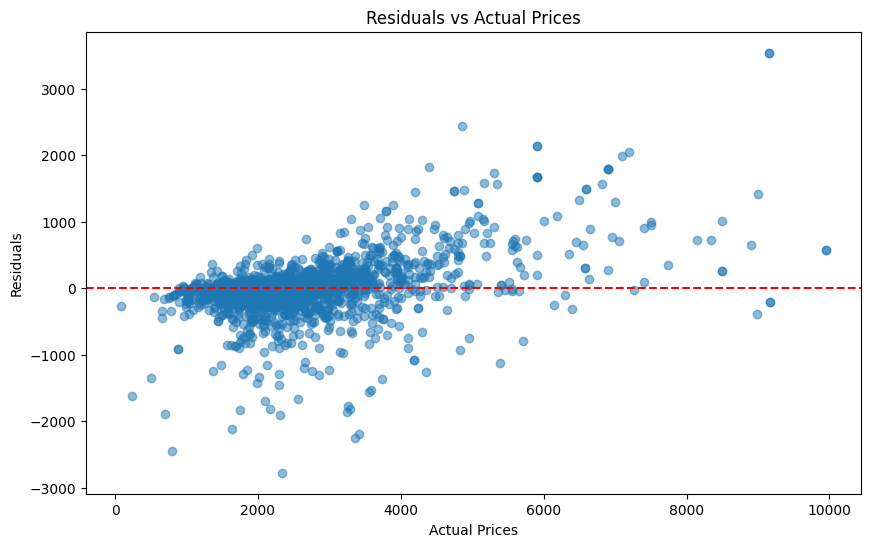

In [36]:
# Calculate residuals

plt.figure(figsize=(10, 6))
plt.scatter(y_train, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Actual Prices')
plt.ylabel('Residuals')
plt.title('Residuals vs Actual Prices')
plt.show()

### Model Performance

In [37]:
def model_performance(features, df, random_forest_model = RandomForestRegressor(random_state=42)):
    df = df.sample(frac=1, random_state=42)
    X, y = df[features], df['price']
    scores = cross_val_score(random_forest_model, X, y, scoring="neg_root_mean_squared_error", cv=5)
    print('CV results RMSE:', np.round(scores))
    print('Mean RMSE:', np.mean(np.round(scores, 0)))

In [38]:
features = ['rooms', 'area', 'pop', 'pop_dens', 'frg_pct', 'emp', 'tax_income']
model_performance(features, df_data)

CV results RMSE: [-837. -687. -749. -891. -629.]
Mean RMSE: -758.6


## Feature Engineering

In [39]:
# Define Zurich HB (City Center) coordinates
ZURICH_HB_LAT = 47.378177
ZURICH_HB_LON = 8.540192

# Function to calculate Haversine distance (great-circle distance)
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in kilometers
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])  # Convert degrees to radians
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c  # Distance in km

# Apply function to dataset to compute distance to Zürich HB
df_data["distance_to_zurich_hb_in_km"] = df_data.apply(
    lambda row: haversine(row["lat"], row["lon"], ZURICH_HB_LAT, ZURICH_HB_LON), axis=1
)
print(df_data)

      bfs_number  rooms  area  price  postalcode  \
0            261    4.5   148   4180        8050   
1            261    2.0   122   3190        8050   
2            261    3.5    78   2780        8050   
3            261    3.5    69   3750        8050   
4            261    3.5    74   2390        8050   
...          ...    ...   ...    ...         ...   
2395           3    4.5   104   2055        8906   
2396         196    4.5    98   1950        8617   
2397           4    5.5   175   3720        8915   
2398         173    4.5   130   2400        8335   
2399         192    3.5   102   2272        8132   

                                     address              town  \
0       Schaffhauserstrasse 363, 8050 Zürich            Zürich   
1              Max Bill Platz 5, 8050 Zürich            Zürich   
2          Regensbergstrasse 30, 8050 Zürich            Zürich   
3             Dörflistrasse 112, 8050 Zürich            Zürich   
4       Schaffhauserstrasse 445, 8050 Zürich 

In [40]:
features = ['rooms', 'area', 'pop', 'pop_dens', 'frg_pct', 'emp', 'tax_income', 'distance_to_zurich_hb_in_km']
model_performance(features, df_data)

CV results RMSE: [-728. -587. -692. -829. -523.]
Mean RMSE: -671.8


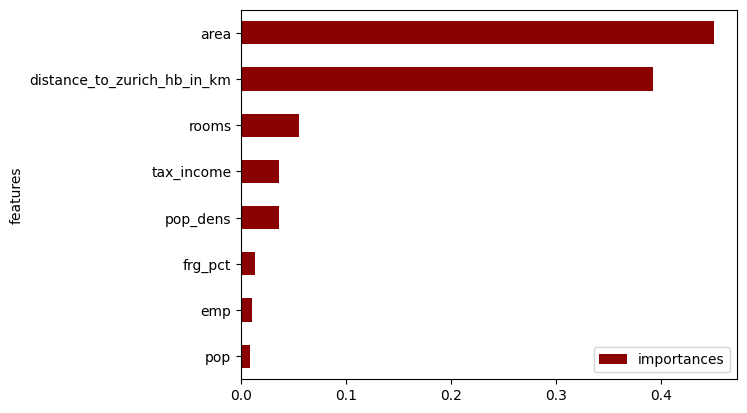

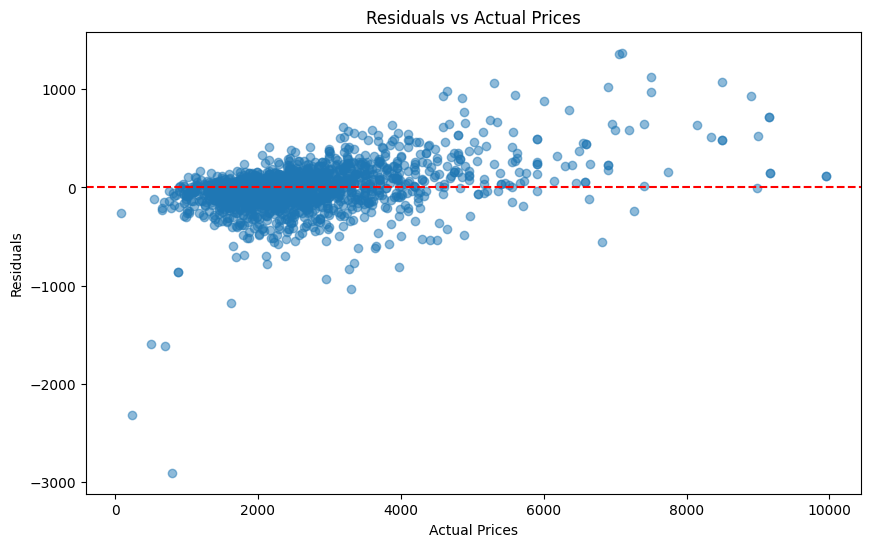

In [41]:
# train random_forest_model = RandomForestRegressor()
random_forest_model = RandomForestRegressor(random_state=42)

# Fit the model
random_forest_model.fit(df_data[features], df_data.price)

cols = random_forest_model.feature_names_in_

# Derive feature importance from random forest
importances = random_forest_model.feature_importances_
std         = np.std([tree.feature_importances_ for tree in random_forest_model.estimators_], axis=0)
indices     = np.argsort(importances)[::-1]

# Barplot with feature importance
df_fi = pd.DataFrame({'features':cols,'importances': importances})
df_fi.sort_values('importances', inplace=True)
df_fi.plot(kind='barh', 
           y='importances',
           x='features', 
           color='darkred')

# Create train and test samples
X_train, X_test, y_train, y_test = train_test_split(df_data[features], 
                                                         df_data['price'], 
                                                        test_size=0.20, 
                                                        random_state=42)

# make predictions
y_train_predict = random_forest_model.predict(X_train)
residuals = y_train - y_train_predict

# Calculate residuals

plt.figure(figsize=(10, 6))
plt.scatter(y_train, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Actual Prices')
plt.ylabel('Residuals')
plt.title('Residuals vs Actual Prices')
plt.show()

### Save Model

In [42]:
model_filename = "random_forest_regression_Distance_Zurich.pkl"

joblib.dump(random_forest_model, model_filename)

['random_forest_regression_Distance_Zurich.pkl']

### Town Data

In [43]:
df_bfs_data = pd.read_csv('bfs_municipality_and_tax_data.csv', sep=',', encoding='utf-8')
df_bfs_data['tax_income'] = df_bfs_data['tax_income'].str.replace("'", "").astype(float)

locations = {
    "Zürich": 261,
    "Kloten": 62,
    "Uster": 198,
    "Illnau-Effretikon": 296,
    "Feuerthalen": 27,
    "Pfäffikon": 177,
    "Ottenbach": 11,
    "Dübendorf": 191,
    "Richterswil": 138,
    "Maur": 195,
    "Embrach": 56,
    "Bülach": 53,
    "Winterthur": 230,
    "Oetwil am See": 157,
    "Russikon": 178,
    "Obfelden": 10,
    "Wald (ZH)": 120,
    "Niederweningen": 91,
    "Dällikon": 84,
    "Buchs (ZH)": 83,
    "Rüti (ZH)": 118,
    "Hittnau": 173,
    "Bassersdorf": 52,
    "Glattfelden": 58,
    "Opfikon": 66,
    "Hinwil": 117,
    "Regensberg": 95,
    "Langnau am Albis": 136,
    "Dietikon": 243,
    "Erlenbach (ZH)": 151,
    "Kappel am Albis": 6,
    "Stäfa": 158,
    "Zell (ZH)": 231,
    "Turbenthal": 228,
    "Oberglatt": 92,
    "Winkel": 72,
    "Volketswil": 199,
    "Kilchberg (ZH)": 135,
    "Wetzikon (ZH)": 121,
    "Zumikon": 160,
    "Weisslingen": 180,
    "Elsau": 219,
    "Hettlingen": 221,
    "Rüschlikon": 139,
    "Stallikon": 13,
    "Dielsdorf": 86,
    "Wallisellen": 69,
    "Dietlikon": 54,
    "Meilen": 156,
    "Wangen-Brüttisellen": 200,
    "Flaach": 28,
    "Regensdorf": 96,
    "Niederhasli": 90,
    "Bauma": 297,
    "Aesch (ZH)": 241,
    "Schlieren": 247,
    "Dürnten": 113,
    "Unterengstringen": 249,
    "Gossau (ZH)": 115,
    "Oberengstringen": 245,
    "Schleinikon": 98,
    "Aeugst am Albis": 1,
    "Rheinau": 38,
    "Höri": 60,
    "Rickenbach (ZH)": 225,
    "Rafz": 67,
    "Adliswil": 131,
    "Zollikon": 161,
    "Urdorf": 250,
    "Hombrechtikon": 153,
    "Birmensdorf (ZH)": 242,
    "Fehraltorf": 172,
    "Weiach": 102,
    "Männedorf": 155,
    "Küsnacht (ZH)": 154,
    "Hausen am Albis": 4,
    "Hochfelden": 59,
    "Fällanden": 193,
    "Greifensee": 194,
    "Mönchaltorf": 196,
    "Dägerlen": 214,
    "Thalheim an der Thur": 39,
    "Uetikon am See": 159,
    "Seuzach": 227,
    "Uitikon": 248,
    "Affoltern am Albis": 2,
    "Geroldswil": 244,
    "Niederglatt": 89,
    "Thalwil": 141,
    "Rorbas": 68,
    "Pfungen": 224,
    "Weiningen (ZH)": 251,
    "Bubikon": 112,
    "Neftenbach": 223,
    "Mettmenstetten": 9,
    "Otelfingen": 94,
    "Flurlingen": 29,
    "Stadel": 100,
    "Grüningen": 116,
    "Henggart": 31,
    "Dachsen": 25,
    "Bonstetten": 3,
    "Bachenbülach": 51,
    "Horgen": 295
}

## Build Website

In [44]:


# Define the core prediction function
def predict_apartment(rooms, area, town, distancetohb):
    bfs_number = locations[town]
    df = df_bfs_data[df_bfs_data['bfs_number']==bfs_number].copy()
    df.reset_index(inplace=True)
    df.loc[0, 'rooms'] = rooms
    df.loc[0, 'area'] = area
    df.loc[0, 'distance_to_zurich_hb_in_km'] = distancetohb
    if len(df) != 1: # if there are more than two records with the same bfs_number reutrn -1
        return -1
    prediction = random_forest_model.predict(df[['rooms', 'area', 'pop', 'pop_dens', 'frg_pct', 'emp', 'tax_income', 'distance_to_zurich_hb_in_km']])
    return np.round(prediction[0], 0)

print(predict_apartment(3, 100, 'Zürich', 15))

# Create Gradio interface
iFace = gr.Interface(
    fn=predict_apartment,
    inputs=[
        gr.Number(label="Rooms"),
        gr.Number(label="Area"),
        gr.Dropdown(choices=locations.keys(), label="Town", type="value"),
        gr.Number(label="Distance To Zürich HB in km")
    ],
    outputs=[gr.Number()],
    examples=[
        [5.1, 3.5, 'Dietlikon', 0.2],
        [6.2, 2.9, 'Winterthur', 1.3],
        [7.7, 3.8, 'Zürich', 2.2],
    ],
    title="Apartment price Prediction",
    description="Enter the Apartment details to predict the price"
)

iFace.launch()


2922.0
* Running on local URL:  http://127.0.0.1:7863

To create a public link, set `share=True` in `launch()`.
